### WGU D213 Advanced Data Analytics
# Task 2 - Sentiment Analysis Using Neural Networks

#### Ednalyn C. De Dios
#### August 27, 2023


# Environment

- Python: 3.9.9
- Jupyter: 7.0.2

# Part I. Research Question

## A1.  Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen data set(s).

> ### _Can we predict the sentiment of a comment using previous comments?_

## A2. Define the objectives or goals of the data analysis. Be sure the objectives or goals are reasonable within the scope of the research question and are represented in the available data.

The objective of this analysis is to build and train a model that can predict whether a comment is favorable or not.

## A3. Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.

We will use Recurrent Neural Networks for this analysis.

In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np

# natural language processing
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read tsv data
colnames=['text', 'label'] 
df_amazon = pd.read_csv('../data/amazon_cells_labelled.txt', sep='\t', names=colnames, header=None)
df_imdb = pd.read_csv('../data/imdb_labelled.txt', sep='\t', names=colnames, header=None)
df_yelp = pd.read_csv('../data/yelp_labelled.txt', sep='\t', names=colnames, header=None)
df = pd.concat([df_amazon, df_imdb, df_yelp])
df = df.reset_index(drop=True)

In [3]:
df.shape

(2748, 2)

In [4]:
df.head()
df.tail()

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


,text,label
2743,I think food should have flavor and texture and both were lacking.,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


# Part II. Data Preparation

## B1.  Perform exploratory data analysis on the chosen data set, and include an explanation of each of the following elements:

- presence of unusual characters (e.g., emojis, non-English characters)
- vocabulary size
- proposed word embedding length
- statistical justification for the chosen maximum sequence length

In [5]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
text,0,0.0,0,0.0,0,0.0
label,0,0.0,0,0.0,0,0.0


In [6]:
def isEnglish(c):
    try:
        c.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [7]:
non_english = []
for index, row in df.iterrows():
    for l in list(row['text']):
        for c in l:
            if isEnglish(c) == True:
                pass
            else:
                non_english.append(c)
non_english[:10]

['\x96', 'é', '\x85', '\x96', 'é', 'é', 'å', '\x96', '\x97', '\x96']

In [8]:
# presence of unusual characters, punctuations, etc
df.head(99)

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up right to get decent volume.,0
6,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.",0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


In [9]:
ADDITIONAL_STOPWORDS = []

def clean_sentence(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return word_list

In [10]:
def get_words(df, column):
    """
    Takes a dataframe and a column and returns a list of
    cleaned words that is returned by clean().

            Parameters:
                    df (dataframe): A pandas dataframe
                    column (series): A pandas series

            Returns:
                    word_list (list): A list of cleaned words
    """
    return clean_sentence(''.join(str(df[column].tolist())))

In [11]:
df_csat =  df.loc[df['label'] == 1]
df_dsat =  df.loc[df['label'] == 0]

In [12]:
all_words = get_words(df, 'text')
csat_words = get_words(df_csat, 'text')
dsat_words = get_words(df_dsat, 'text')

In [13]:
csat_freq = pd.Series(csat_words).value_counts()
dsat_freq = pd.Series(dsat_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

word_counts = (pd.concat([all_freq, csat_freq, dsat_freq], axis=1, sort=True)
                .set_axis(['all', 'csat', 'dsat'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [14]:
print('VOCABULARY SIZE')
print('=====================================')
print('Favorable comments: ' + str(len(csat_freq)))
print('Unfavorable comments: ' + str(len(dsat_freq)))
print('All comments: ' + str(len(all_freq)))

VOCABULARY SIZE
Favorable comments: 3102
Unfavorable comments: 3197
All comments: 4967


In [15]:
vocab_size = len(all_freq)
vocab_size

4967

In [16]:
# What are the most frequently occuring words?
word_counts.sort_values(by='all', ascending=False).head(10)

,all,csat,dsat
good,226,170,56
movie,208,101,107
great,205,188,17
film,182,96,86
phone,173,91,82
one,145,69,76
time,133,57,76
like,127,61,66
food,125,60,65
place,123,62,61


In [17]:
# Are there any words that uniquely identify a dsat or csat comment?
pd.concat([word_counts[word_counts.dsat == 0].sort_values(by='csat').tail(10),
           word_counts[word_counts.csat == 0].sort_values(by='dsat').tail(10)])

,all,csat,dsat
priced,7,7,0
town,7,7,0
joy,7,7,0
superb,7,7,0
brilliant,7,7,0
role,9,9,0
pleased,10,10,0
interesting,15,15,0
fantastic,18,18,0
delicious,23,23,0


In [18]:
def get_unigrams(words):
    """
    Takes in a list of words and returns a series of
    unigrams with value counts.
    """
    return  pd.Series(words).value_counts()

def get_bigrams(words):
    """
    Takes in a list of words and returns a series of
    bigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

def get_trigrams(words):
    """
    Takes in a list of words and returns a series of
    trigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

def get_qualgrams(words):
    """
    Takes in a list of words and returns a series of
    qualgrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 4)).value_counts())[:20]

def get_ngrams(df,column):
    """
    Takes in a dataframe with column name and generates a
    dataframe of unigrams, bigrams, trigrams, and qualgrams.
    """
    return get_bigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'bigram','0':'count'}), \
           get_trigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'trigram','0':'count'}), \
           get_qualgrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'qualgram','0':'count'})

In [19]:
def viz_bigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of bigrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

def viz_trigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of trigrams.
    """
    get_trigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')
    
def viz_qualgrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of qualgrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Qualgram')
    plt.xlabel('# Occurances')

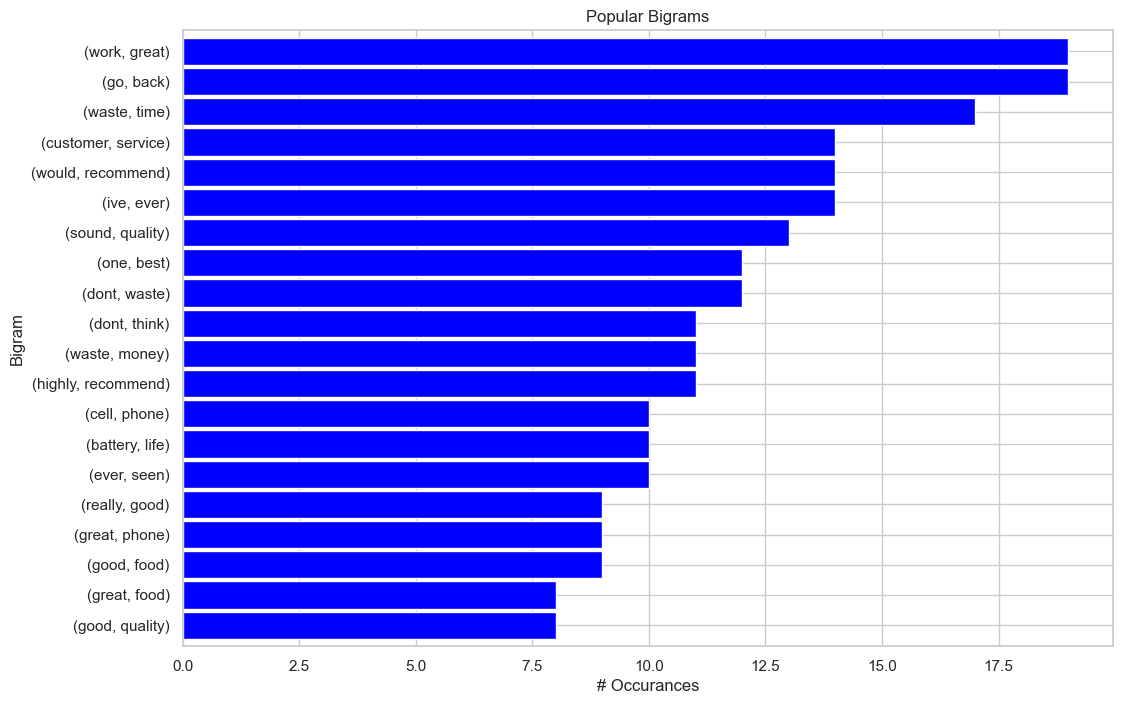

In [20]:
viz_bigrams(df, 'text', 'Popular Bigrams')

In [21]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Max sequence embedding: ' + str(max_sequence_embedding))

Max sequence embedding: 8


In [22]:
list_of_lens = []
for index, row in df.iterrows():
    list_of_lens.append(len(clean_sentence(row['text'])))
sequence_length = max(list_of_lens)
print('Sequence length: ' + str(sequence_length))

Sequence length: 789


In [23]:
sequence_length = max(list_of_lens)
mean_sequence_length = int(round(np.mean(list_of_lens), 0))
print('Mean sequence length: ' + str(mean_sequence_length))

Mean sequence length: 7


In [24]:
df.head()

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


In [25]:
df['cleaned_text'] = df["text"].apply(clean_sentence)

In [26]:
df.head()

,text,label,cleaned_text
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,"[way, plug, u, unless, go, converter]"
1,"Good case, Excellent value.",1,"[good, case, excellent, value]"
2,Great for the jawbone.,1,"[great, jawbone]"
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,"[tied, charger, conversation, lasting, 45, minutesmajor, problem]"
4,The mic is great.,1,"[mic, great]"


In [27]:
sentences = df['cleaned_text'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=.25, random_state=493)
sentences_train, sentences_val, y_train, y_valid = train_test_split(sentences_train, y_train, test_size=.2, random_state=493)

In [28]:
vocab_size = 4967
oov_tok = '<OOV>'
max_length = 7
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_train)
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(sentences_train)
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

sequences_test = tokenizer.texts_to_sequences(sentences_train)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [29]:
activation = 'softmax'
loss = 'categorical_crossentropy'
optimizer = 'adam'

num_epochs = 20

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=2)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, max_sequence_embedding, input_length=max_length),
    tf.keras.layers.LSTM(3),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation=activation),
])

model.compile(loss=loss, optimizer=optimizer, callbacks=[early_stopping_monitor], metrics=['accuracy'])

TypeError: Invalid keyword argument(s) in `compile()`: ({'callbacks'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".

In [ ]:
model.summary()

# history = model.fit(padded_train, y_train, batch_size=32, epochs=num_epochs, validation_split = 0.3, callbacks=[early_stopping_monitor], verbose=True)

model.fit(np.array(padded_train), np.array(y_train), verbose=0, epochs=100)

score = model.evaluate(padded_test, y_test, verbose=0)
score[0]
score[1]

# Part VI. Reporting

## H. Show your neural network in an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

- Filename: "D213 Performance Assessment Task 2 (Rev. 0).pdf"
- Filename: "D213 Performance Assessment Task 2 (Rev. 0).ipynb"


## I. Denote specific web sources you used to acquire segments of third-party code that was used to support the application.

- https://github.com/ecdedios/code-snippets/blob/main/notebooks/master.ipynb
- https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python

## J. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

- https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences